# 1. Imports 

In [1]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'


# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()


# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_v3.csv')

Using TensorFlow backend


# 2. Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)
x_obs = x_scaler.transform(X_obs.values)



c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [3]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[1]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# 3. NN Training

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

#normalize = layers.Normalization()

# This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
# It accomplishes this by precomputing the mean and variance of the data and calling (input - mean) / sqrt(var) at runtime

# TODO: Probar con los datos sin normalizar
#normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  #normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [5]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 701, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 701, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 234, 32)          0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 234, 64)           4160      
                                                             

In [6]:
model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=30)

Epoch 1/30
459/459 [==============================] - 10s 13ms/step - loss: 0.0727 - MAE: 0.2216 - val_loss: 0.0444 - val_MAE: 0.1666
Epoch 2/30
459/459 [==============================] - 6s 12ms/step - loss: 0.0301 - MAE: 0.1309 - val_loss: 0.0219 - val_MAE: 0.1132
Epoch 3/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0163 - MAE: 0.0931 - val_loss: 0.0135 - val_MAE: 0.0829
Epoch 4/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0097 - MAE: 0.0705 - val_loss: 0.0094 - val_MAE: 0.0678
Epoch 5/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0069 - MAE: 0.0598 - val_loss: 0.0054 - val_MAE: 0.0527
Epoch 6/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0052 - MAE: 0.0521 - val_loss: 0.0057 - val_MAE: 0.0559
Epoch 7/30
459/459 [==============================] - 6s 12ms/step - loss: 0.0046 - MAE: 0.0485 - val_loss: 0.0062 - val_MAE: 0.0552
Epoch 8/30
459/459 [==============================] - 6s 12ms/step -

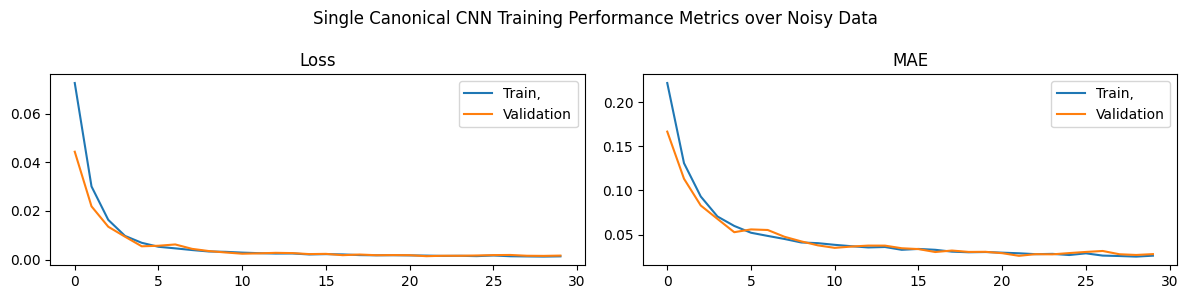

In [7]:
fig, axis = plt.subplots(1, 2, figsize=(12,3))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')

# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.suptitle('Single Canonical CNN Training Performance Metrics over Noisy Data')
plt.tight_layout()
plt.show()

In [8]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(x_test, y_test)

print('loss: %.4f  MAE:%.4f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 5ms/step - loss: 0.0017 - MAE: 0.0279
loss: 0.0017  MAE:0.0279


In [9]:
predictions = model.predict(x_test)

153/153 [==============================] - 1s 3ms/step


In [10]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.4f  MAE:%.4f'% (losses[0],maes[0]))
print('log g -       loss: %.4f  MAE:%.4f'% (losses[1],maes[1]))
print('v -           loss: %.4f  MAE:%.4f'% (losses[2],maes[2]))


Temperatura - loss: 0.0029  MAE:0.0364
log g -       loss: 0.0013  MAE:0.0262
v -           loss: 0.0008  MAE:0.0212


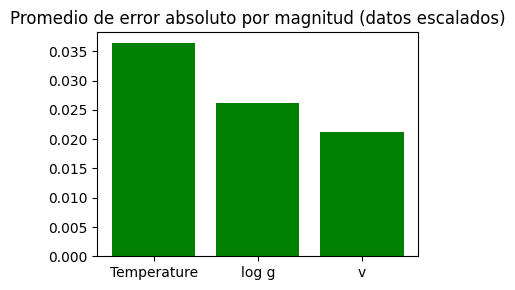

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(predictions-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [12]:
predictions = y_scaler.inverse_transform(predictions)

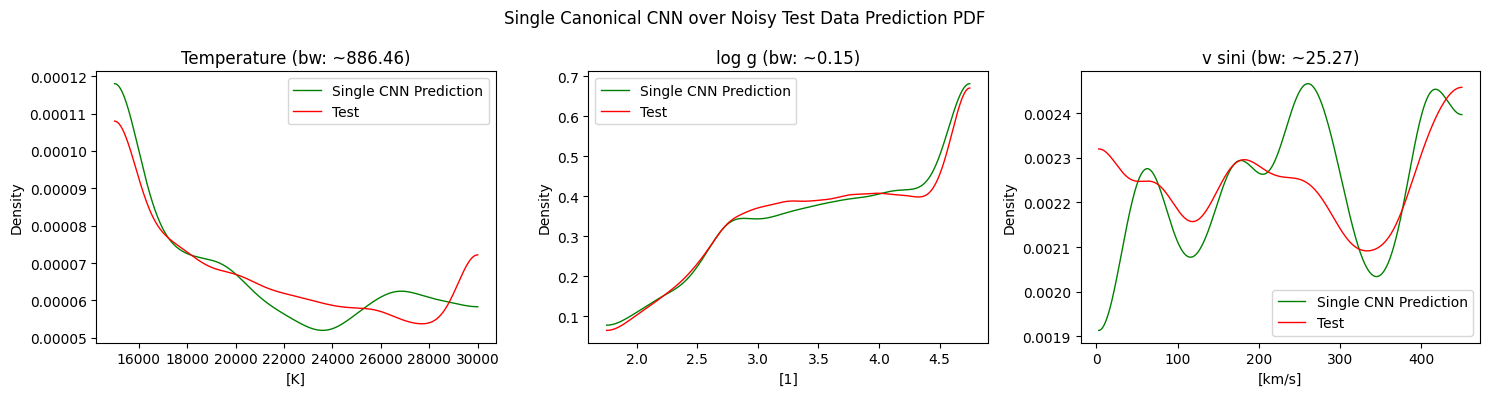

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Single CNN Prediction')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Density')
	axes[i].set_title(measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.suptitle('Single Canonical CNN over Noisy Test Data Prediction PDF')
plt.legend()
plt.tight_layout();
plt.show()

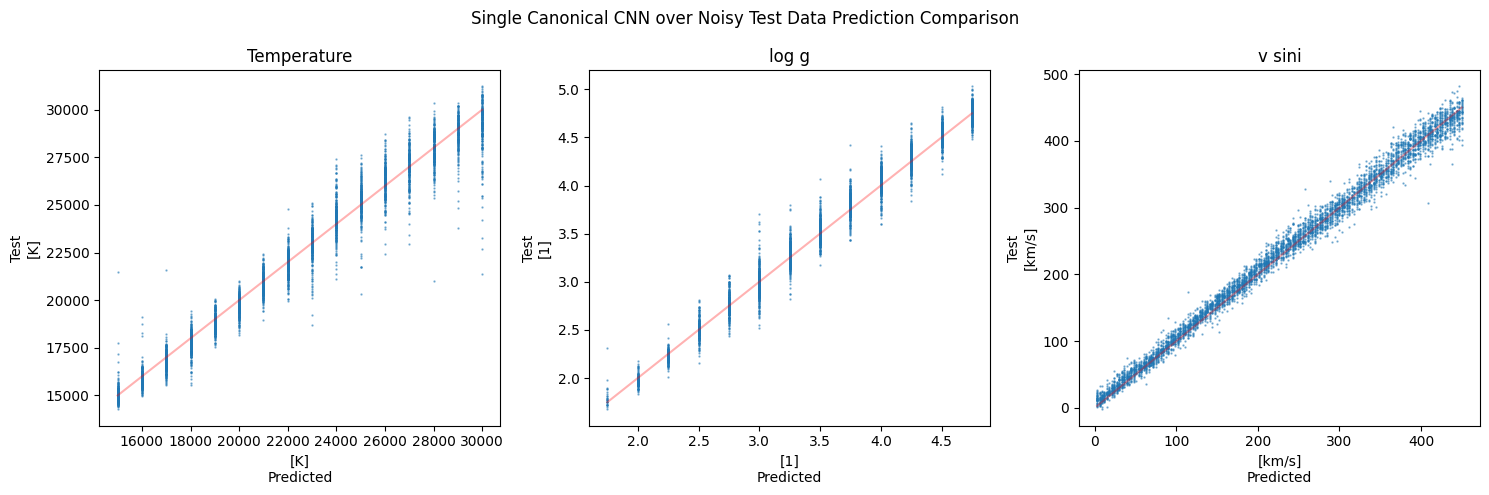

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Canonical CNN over Noisy Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

## Resultados datos de testing

In [15]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [16]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(20)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17570,570 (3.4%),3.25,3.22,0.03 (1.0%),246,249,3 (1.2%)
1,18000,18720,720 (4.0%),2.75,2.82,0.07 (2.5%),285,270,15 (5.2%)
2,30000,30750,750 (2.5%),3.75,3.84,0.09 (2.5%),267,262,5 (1.9%)
3,23000,24680,1680 (7.3%),2.5,2.64,0.14 (5.6%),63,76,13 (21.3%)
4,19000,19763,763 (4.0%),3.0,3.02,0.02 (0.7%),126,135,9 (6.8%)
5,17000,17031,31 (0.2%),4.5,4.55,0.05 (1.1%),156,176,20 (13.0%)
6,28000,25886,2114 (7.5%),3.25,3.13,0.12 (3.5%),450,434,16 (3.4%)
7,22000,20971,1029 (4.7%),4.0,3.98,0.02 (0.5%),285,292,7 (2.4%)
8,23000,24091,1091 (4.7%),3.0,3.04,0.04 (1.2%),30,32,2 (7.3%)
9,23000,23220,220 (1.0%),4.5,4.58,0.08 (1.7%),153,156,3 (1.8%)


## Datos Observados

In [17]:
predictions = model.predict(x_obs)

8/8 [==============================] - 0s 37ms/step


In [18]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.124  MAE:0.275
log g -       loss: 0.257  MAE:0.351
v -           loss: 0.088  MAE:0.222


In [19]:
predictions = y_scaler.inverse_transform(predictions)

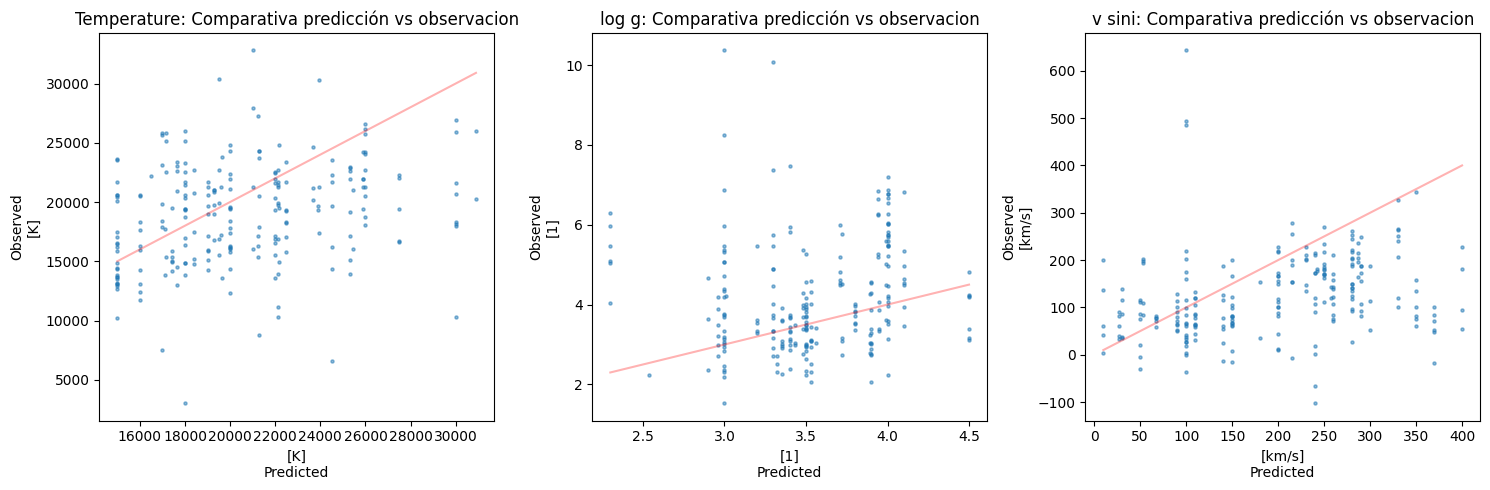

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [21]:
# xi
def xi(obs,sint):
  return np.sum((obs - sint)**2/sint)
def get_closest_spectra_line(index):
  obs = x_obs[index]
  min_dist = np.inf
  min_dist_index = -1
  for i, sint in enumerate(x):
    
    d = xi(obs, sint)
    if d < min_dist:
      min_dist = d
      min_dist_index = i
      
  return min_dist, min_dist_index

In [22]:
# find closest parameters
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
  
nearest = []
for obs_parameters in Y_obs.to_numpy():
	neighbor = []
	for param_index in range(len(target)):
		v, _ = find_nearest(Y.iloc[:,param_index].values,obs_parameters[param_index])
		neighbor.append(v)
	nearest.append(neighbor)
 
nearest_index = []
for neighbor in nearest:
	nearest_index.append(Y[(Y.temperature == neighbor[0]) & (Y.g == neighbor[1]) & (Y.v == neighbor[2])].index[0])

In [23]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)
#close = np.array([get_closest_spectra_line(index) for index in range(len(X_obs))])[:,0]

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

# xi es la distancia entre el espectro observado y el espectro sintetico que tiene parámetros más cercanos a la estrella
table_formatted_xi = [xi(obs,sint) for obs, sint in zip(x_obs,X.iloc[nearest_index].to_numpy())]


In [24]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
102776,2014-01-30,05-09-05,20000,16239,3761 (18.8%),3.2,3.33,0.13 (4.2%),200,173,27 (13.7%),137.768957
102776,2014-03-19,07-07-14,20000,19394,606 (3.0%),3.2,5.47,2.27 (70.8%),200,166,34 (17.0%),609.741368
102776,2015-02-27,07-12-10,20000,18372,1628 (8.1%),3.2,3.62,0.42 (13.3%),200,155,45 (22.5%),156.239384
102776,2015-05-06,02-32-51,20000,16129,3871 (19.4%),3.2,3.53,0.33 (10.3%),200,227,27 (13.4%),144.449077
102776,2015-05-06,02-43-49,20000,19579,421 (2.1%),3.2,3.28,0.08 (2.6%),200,167,33 (16.7%),143.288667
105382,2014-01-30,05-42-57,15000,15907,907 (6.0%),3.4,3.73,0.33 (9.6%),68,58,9 (13.7%),162.497444
105382,2015-02-26,08-22-40,15000,13539,1461 (9.7%),3.4,2.86,0.54 (16.0%),68,77,9 (13.8%),129.533487
105382,2015-02-26,08-43-24,15000,16209,1209 (8.1%),3.4,2.4,1.0 (29.4%),68,78,11 (15.6%),147.298934
105382,2015-05-07,00-20-44,15000,23549,8549 (57.0%),3.4,2.99,0.41 (12.1%),68,71,3 (4.7%),154.595374


# 4. Ensemble

In [25]:
import time
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

# set timer
curr_time = time.time()

In [26]:
from keras.optimizers import Adam

NUM_MODELS = 10
models = [generate_model() for i in range(NUM_MODELS)]
history = []


for i, model in enumerate(models):
	optimizer = Adam()
	model.compile(loss='MSE',optimizer=optimizer)
	history.append(model.fit(x=x_train, y=y_train, epochs=30))

Epoch 1/30
459/459 [==============================] - 6s 11ms/step - loss: 0.0757
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0326
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0166
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0103
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0071
Epoch 6/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0051
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0044
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0036
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0032
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0030
Epoch 11/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0027
Epoch 12/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0025
Epoch 13/30
4

In [27]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 26 minutes, 5.004385 seconds  ---


In [28]:
predictions = np.array([y_scaler.inverse_transform(model.predict(x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 1s 4ms/step


In [29]:
weights = [model.evaluate(x_val, y_val) for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 1s 5ms/step - loss: 0.0016


In [30]:
# metricas por parametro

losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.4f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.4f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.4f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.0017  MAE:0.030
log g -       loss: 0.0008  MAE:0.020
v -           loss: 0.0005  MAE:0.016


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


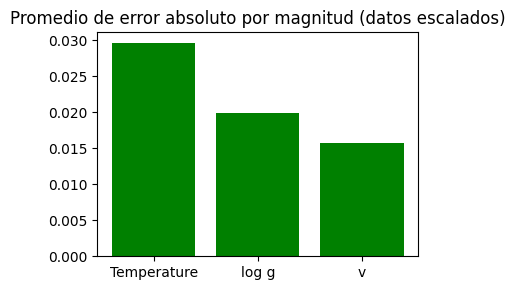

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(ensemble_prediction)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


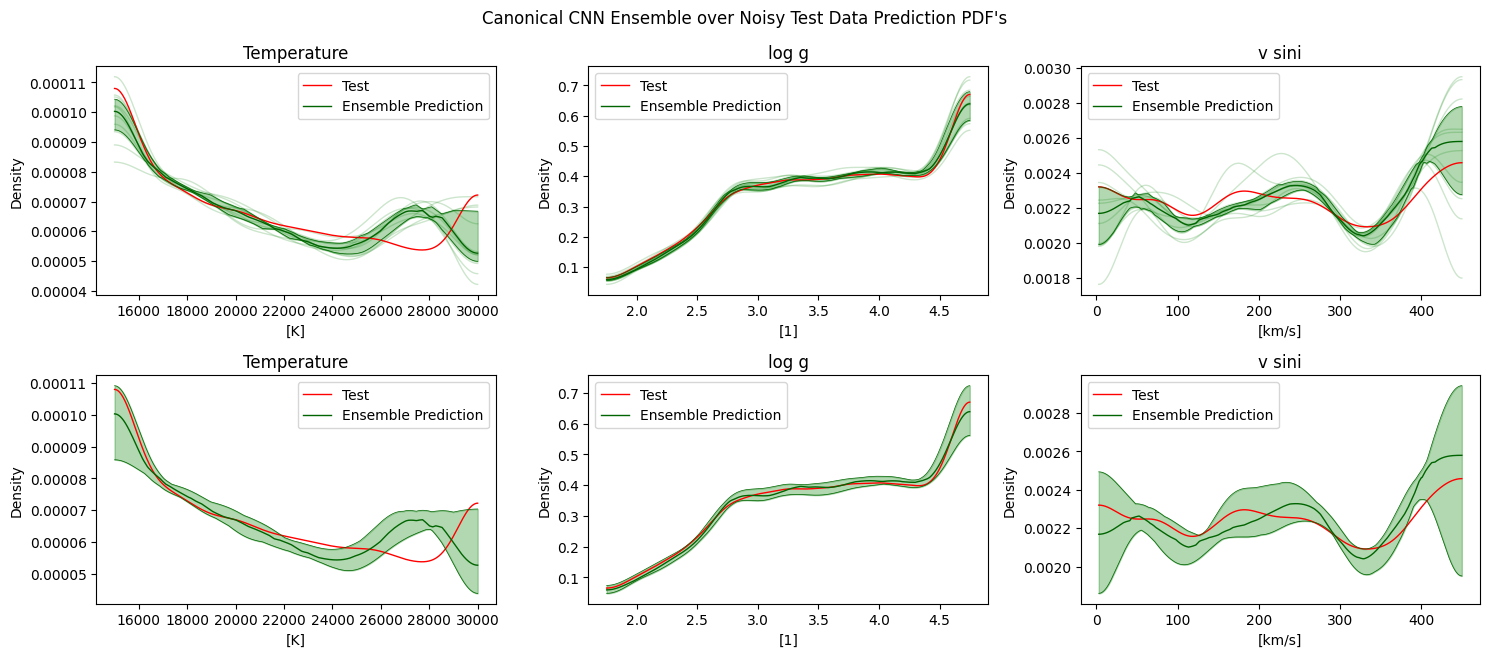

In [32]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Density')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Density')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])

plt.suptitle('Canonical CNN Ensemble over Noisy Test Data Prediction PDF\'s')
plt.tight_layout()
plt.show()

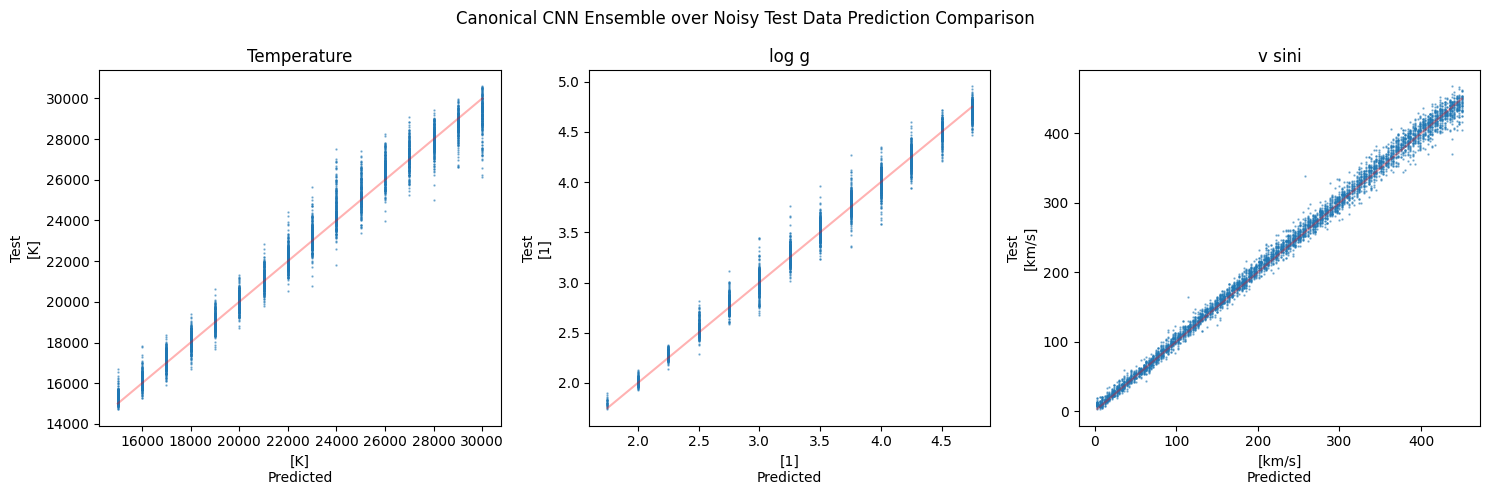

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Canonical CNN Ensemble over Noisy Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

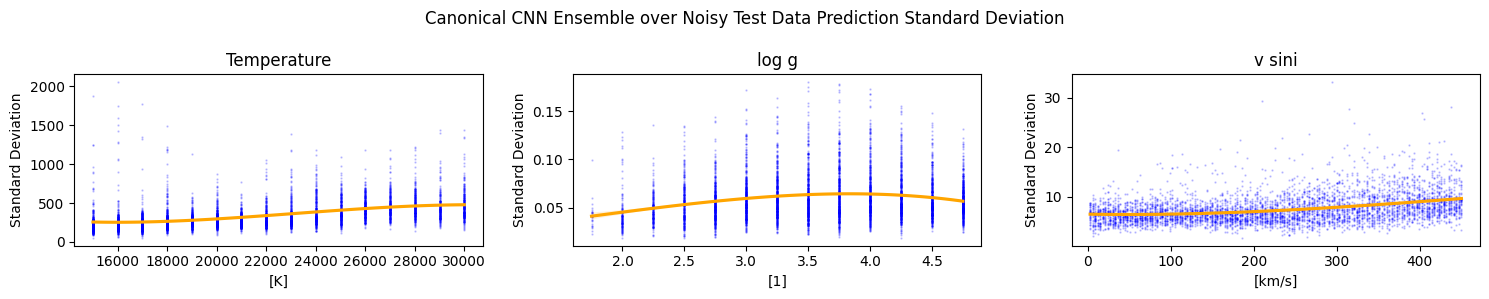

In [34]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temperatura':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temperatura', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Standard Deviation")
	axes[i].set_title(measure[i])
	#axes[i].legend()

plt.suptitle('Canonical CNN Ensemble over Noisy Test Data Prediction Standard Deviation')
plt.tight_layout()
plt.show()

In [35]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(ensemble_prediction-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(ensemble_prediction-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [36]:
# dataframe comparativo de datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
results.head(20)

,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17956 ± 197,956.0 (5.6%),3.25,3.18 ± 0.03,0.07 (2.2%),246,253 ± 4,7.0 (3.0%)
1,18000,18793 ± 230,793.0 (4.4%),2.75,2.81 ± 0.04,0.06 (2.2%),285,278 ± 7,7.0 (2.5%)
2,30000,30237 ± 563,237.0 (0.8%),3.75,3.74 ± 0.07,0.01 (0.3%),267,269 ± 6,2.0 (0.6%)
3,23000,25137 ± 623,2137.0 (9.3%),2.5,2.69 ± 0.06,0.19 (7.4%),63,72 ± 6,9.0 (15.1%)
4,19000,19661 ± 278,661.0 (3.5%),3.0,3.07 ± 0.05,0.07 (2.2%),126,129 ± 7,3.0 (2.6%)
5,17000,17111 ± 174,111.0 (0.7%),4.5,4.52 ± 0.07,0.02 (0.5%),156,166 ± 6,10.0 (6.4%)
6,28000,27996 ± 478,4.0 (0.0%),3.25,3.23 ± 0.06,0.02 (0.6%),450,434 ± 13,16.0 (3.6%)
7,22000,21217 ± 323,783.0 (3.6%),4.0,3.94 ± 0.05,0.06 (1.4%),285,290 ± 8,5.0 (1.6%)
8,23000,23306 ± 360,306.0 (1.3%),3.0,2.99 ± 0.05,0.01 (0.4%),30,33 ± 6,3.0 (10.9%)
9,23000,23535 ± 277,535.0 (2.3%),4.5,4.53 ± 0.03,0.03 (0.6%),153,153 ± 6,0.0 (0.0%)


# Espectro Observado

In [37]:
predictions = np.array([y_scaler.inverse_transform(model.predict(x_obs)) for model in models])

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)

5/8 [=================>............] - ETA: 0s

8/8 [==============================] - 0s 4ms/step


In [38]:
# metricas por parametro
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.107  MAE:0.258
log g -       loss: 0.337  MAE:0.339
v -           loss: 0.104  MAE:0.248


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

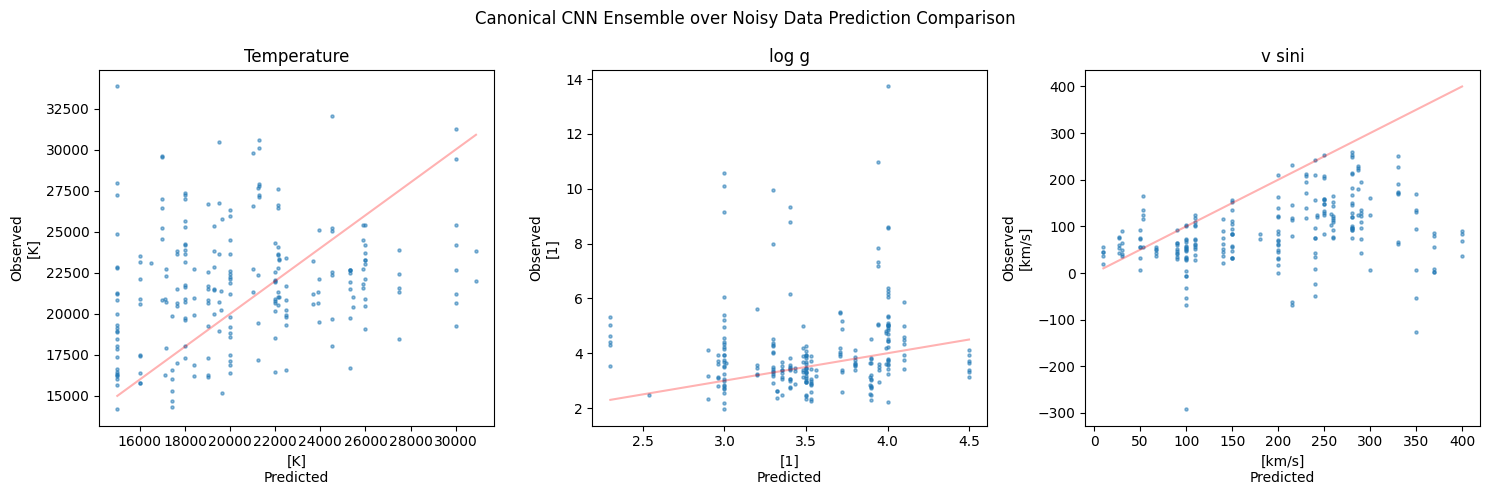

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=ensemble_prediction[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Canonical CNN Ensemble over Noisy Data Prediction Comparison')
plt.tight_layout();
plt.show()

In [40]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [41]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
102776,2014-01-30,05-09-05,20000,18602 ± 3106,1398.0 (7.0%),3.2,3.24 ± 0.21,0.04 (1.3%),200,164 ± 18,36.0 (18.1%),137.768957
102776,2014-03-19,07-07-14,20000,25982 ± 5750,5982.0 (29.9%),3.2,5.63 ± 1.98,2.43 (75.9%),200,30 ± 108,170.0 (84.8%),609.741368
102776,2015-02-27,07-12-10,20000,18820 ± 1171,1180.0 (5.9%),3.2,3.59 ± 0.27,0.39 (12.0%),200,120 ± 21,80.0 (39.8%),156.239384
102776,2015-05-06,02-32-51,20000,16404 ± 611,3596.0 (18.0%),3.2,3.46 ± 0.25,0.26 (8.2%),200,210 ± 16,10.0 (5.0%),144.449077
102776,2015-05-06,02-43-49,20000,22214 ± 2561,2214.0 (11.1%),3.2,3.21 ± 0.29,0.01 (0.4%),200,122 ± 14,78.0 (38.9%),143.288667
105382,2014-01-30,05-42-57,15000,19336 ± 2423,4336.0 (28.9%),3.4,3.84 ± 0.59,0.44 (12.8%),68,52 ± 35,15.0 (22.5%),162.497444
105382,2015-02-26,08-22-40,15000,15663 ± 695,663.0 (4.4%),3.4,2.76 ± 0.15,0.64 (18.8%),68,55 ± 15,13.0 (18.6%),129.533487
105382,2015-02-26,08-43-24,15000,17865 ± 1753,2865.0 (19.1%),3.4,2.74 ± 0.2,0.66 (19.5%),68,43 ± 11,24.0 (35.9%),147.298934
105382,2015-05-07,00-20-44,15000,22808 ± 2060,7808.0 (52.1%),3.4,3.43 ± 0.13,0.03 (1.0%),68,38 ± 18,30.0 (44.3%),154.595374
